# Start-to-Finish Example: Head-On Black Hole Collision

## This module implements a basic numerical relativity code to merge two black holes in *spherical coordinates*

<font color='green'>**This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution *after a short numerical evolution of the initial data* (see plot at bottom), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy).**</font>

### NRPy+ Source Code for this module: 
1. [BSSN/BrillLindquist.py](../edit/BSSN/BrillLindquist.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb): Brill-Lindquist initial data; sets all ADM variables in Cartesian basis: 
1. [BSSN/CartesianADMID_to_BSSNCurvilinearID.py](../edit/BSSN/CartesianADMID_to_BSSNCurvilinearID.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_ADMCartesian_to_BSSNCurvilinear.ipynb): Cartesian ADM$\to$Curvilinear BSSN converter function
1. [BSSN/BSSN_ID_function_string.py](../edit/BSSN/BSSN_ID_function_string.py): Sets up the C code string enabling initial data be set up in a point-by-point fashion
1. [BSSN/BSSN_Constraints.py](../edit/BSSN/BSSNConstraints.py); [\[**tutorial**\]](Tutorial-BSSNConstraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
1. [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSNCurvilinear.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates

Here we use NRPy+ to generate the C source code necessary to set up initial data for two black holes (Brill-Lindquist, [Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. (**Steps 2a and 2b** below) <font color='green'>Set gridfunction values to initial data (**[documented in previous start-to-finish module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_two_BH_initial_data.ipynb)**).</font>
1. Evolve the initial data forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. (**Step 3A** below) <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. (**Step 4** below) Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. (**Step 5** below) <font color='green'>Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint</font>
1. (**Step 3B** below) At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>. (This is in Step 3B, because Step 4 requires that *all* gridfunctions be defined.)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Spherical")

## Step 2a: First import Brill-Lindquist ADM initial data from the BSSN.BrillLindquist NRPy+ module, [documented here](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb)

These initial data are expressed in the Cartesian coordinate basis (i.e., vectors and tensors are expressed in Cartesian components).

In [2]:
import BSSN.BrillLindquist as bl
bl.BrillLindquist()

## Step 2b: Next transform the Brill-Lindquist ADM quantities in Cartesian coordinates to BSSN quantities in curvilinear coordinates, using the BSSN.CartesianADMID_to_BSSNCurvilinearID NRPy+ module, [documented here](Tutorial-ADM_Initial_Data-Converting_ADMCartesian_to_BSSNCurvilinear.ipynb), and output result to file.

In [3]:
import BSSN.CartesianADMID_to_BSSNCurvilinearID as ctob
cf,hDD,lambdaU,aDD,trK,alpha,vetU,betU = \
    ctob.Convert_Cartesian_ADM_to_BSSN_curvilinear(bl.Cartxyz, bl.gammaCartDD, 
                                                   bl.KCartDD, bl.alphaCart, bl.betaCartU, bl.BCartU)
# Now output the Brill-Lindquist initial data to file:
with open("BSSN/BrillLindquist.h","w") as file:
    file.write(bl.returnfunction)

## Step 3A: Output BSSN RHS expressions

In [4]:
import BSSN.BSSN_RHSs as rhs
rhs.BSSN_RHSs()

import time
print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
start = time.time()

BSSN_evol_rhss = [ \
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD00"),rhs=rhs.a_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD01"),rhs=rhs.a_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD02"),rhs=rhs.a_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD11"),rhs=rhs.a_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD12"),rhs=rhs.a_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD22"),rhs=rhs.a_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","alpha"),rhs=rhs.alpha_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU0"),rhs=rhs.bet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU1"),rhs=rhs.bet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU2"),rhs=rhs.bet_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","cf"),   rhs=rhs.cf_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD00"),rhs=rhs.h_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD01"),rhs=rhs.h_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD02"),rhs=rhs.h_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD11"),rhs=rhs.h_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD12"),rhs=rhs.h_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD22"),rhs=rhs.h_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU0"),rhs=rhs.lambda_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU1"),rhs=rhs.lambda_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU2"),rhs=rhs.lambda_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","trK"),  rhs=rhs.trK_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU0"),rhs=rhs.vet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU1"),rhs=rhs.vet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU2"),rhs=rhs.vet_rhsU[2]) ]

BSSN_RHSs_string = fin.FD_outputC("returnstring",BSSN_evol_rhss, params="outCverbose=False")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

with open("BSSN/BSSN_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+BSSN_RHSs_string))

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Generating C code for BSSN RHSs in Spherical coordinates.
Finished in 34.5371668339 seconds.


## Step 3B: Output the Hamiltonian constraint

In [5]:
import BSSN.BSSNConstraints as bssncon
bssncon.BSSNConstraints()

H = gri.register_gridfunctions("AUX","H")

print("Generating C code for Hamiltonian constraint")
start = time.time()
Hamiltonianstring = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs","H"),rhs=bssncon.H), 
                                   params="outCverbose=False")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

with open("BSSN/Hamiltonian.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+Hamiltonianstring))

Generating C code for Hamiltonian constraint
Finished in 9.413615942 seconds.


## Step 4: Apply singular, curvilinear coordinate boundary conditions [*a la* Section IV.E of the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)

### Step 4A: Find locations to where outer ghost zone gridpoints map

We start by following the procedure of the [scalar wave in curvilinear coordinates tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb), to find the locations to where the outer ghost zone gridpoints map. As described in the scalar wave in curvilinear coordinates tutorial, this requires first mapping from the curvilinear coordinate gridpoints $(x_0,x_1,x_2)$ in the outer ghost zones to the corresponding Cartesian grid points $(x,y,z)$ in the grid interior or outer boundary.

### Step 4B: At each ghost zone gridpoint, find and store the correct parity condition type for each gridfunction up to rank 2 (the highest rank in the BSSN RHSs)

Suppose we have a vector $v^\rho$ defined at ghostzone $(-\rho,\phi,z)$ ($\rho>0$) in cylindrical coordinates. This will map to an interior point at $(\rho,\phi+\pi,z)$. At this point, the direction of the $\hat{\rho}$ unit vector flips sign. Thus we cannot simply set the value of $v^\rho$ to the value it possesses at interior point $(\rho,\phi+\pi,z)$; that would result in a sign error. Instead we have
\begin{align}
v^\rho(-\rho,\phi,z)&=-v^\rho(\rho,\phi+\pi,z) \\
&= \mathbf{e}^\rho\left(-\rho,\phi,z\right) \cdot \mathbf{e}^\rho\left(\rho,\phi+\pi,z\right)v^\rho(\rho,\phi+\pi,z),
\end{align}
where $\mathbf{e}^\rho\left(\rho,\phi,z\right)$ is the $\rho$ unit vector evaluated at point $(\rho,\phi,z)$. Contrast this with scalars, which do not possess a sense of direction.

Given this pattern, once the interior grid point $(x_0,x_1,x_2)_{\rm in}$ corresponding to an inner boundary point $(x_0,x_1,x_2)_{\rm IB}$ has been found, the generic procedure to apply these so-called "parity conditions" for a generic rank-$N$ tensor ($N>0$) is as follows:

1. The first component of the rank-$N$ tensor corresponds to some direction with unit vector $\mathbf{e}^i$; e.g., $v^r$ corresponds to the $\mathbf{e}^r$ direction. Compute the dot product of the unit vector $\mathbf{e}^i$ evaluated at points $(x_0,x_1,x_2)_{\rm in}$ and $(x_0,x_1,x_2)_{\rm IB}$. Define this dot product as $S_1$:
$$
S_1 = \mathbf{e}^i\left((x_0,x_1,x_2)_{\rm in}\right) \cdot \mathbf{e}^i\left((x_0,x_1,x_2)_{\rm IB}\right).
$$
1. S_1 will take the value of $\pm 1$, depending on the unit-vector direction and the points $(x_0,x_1,x_2)_{\rm in}$ and $(x_0,x_1,x_2)_{\rm IB}$
1. Repeat the above for the remaining components of the rank-$N$ tensor $j\in \{2,3,...,N\}$, storing each $S_j$.
1. The tensor mapping from $(x_0,x_1,x_2)_{\rm IB}$ to $(x_0,x_1,x_2)_{\rm in}$ for this tensor $T^{ijk...}_{mnp...}$ will be given by
$$
T^{ijk...}_{lmn...}(x_0,x_1,x_2)_{\rm IB} = \prod_{\ell=1}^N S_\ell T^{ijk...}_{mnp...}(x_0,x_1,x_2)_{\rm in}.
$$

In this formulation of BSSN, we only need to deal with rank-0, rank-1, and *symmetric* rank-2 tensors. Further, our basis consists of 3 directions, so there are a total of 
+ 1 parity condition (the trivial +1) for scalars (rank-0 tensors)
+ 3 parity conditions for all rank-1 tensors (corresponding to each direction)
+ 6 parity conditions for all *symmetric* rank-2 tensors (corresponding to the number of elements in the lower or upper triangle of a $3\times3$ matrix, including the diagonal)

Thus we must keep track of the behavior of **10 separate parity conditions**, which can be evaluated once when the simulation begins, for all time. 

In [6]:
# Generic coordinate NRPy+ file output, Part 1: output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")
# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN/xxCart.h")
# Generic coordinate NRPy+ file output, Part 3: output the conversion from Cartesian (x,y,z) to interior/OB (x0,x1,x2)
outputC([rfm.Cart_to_xx[0],rfm.Cart_to_xx[1],rfm.Cart_to_xx[2]],
        ["Cart_to_xx0_inbounds","Cart_to_xx1_inbounds","Cart_to_xx2_inbounds"],
        "BSSN/Cart_to_xx.h")
# Generic coordinate NRPy+ file output, Part 4: output the proper distance between gridpoints in given coordinate system
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"BSSN/ds_dirn.h")

Wrote to file "BSSN/xxCart.h"
Wrote to file "BSSN/Cart_to_xx.h"
Wrote to file "BSSN/ds_dirn.h"


####   Step 4B.i: Set the parity condition for each of the 10 parity condition types

First we fill in the parity condition arrays. These take as input $(x_0,x_1,x_2)_{\rm in}$ and $(x_0,x_1,x_2)_{\rm IB}$, and output the necessary dot products for each parity type. To wit, there are 10 parity types for BSSN evolved variables, which include tensors up to and including rank-2:

0. Scalar (Rank-0 tensor)
1. Rank-1 tensor in **i0** direction
1. Rank-1 tensor in **i1** direction
1. Rank-1 tensor in **i2** direction
1. Rank-2 tensor in **i0-i0** direction
1. Rank-2 tensor in **i0-i1** direction
1. Rank-2 tensor in **i0-i2** direction
1. Rank-2 tensor in **i1-i1** direction
1. Rank-2 tensor in **i1-i2** direction
1. Rank-2 tensor in **i2-i2** direction

In [7]:
parity = ixp.zerorank1(DIM=10)
UnitVectors_inner = ixp.zerorank2()
xx0_inbounds,xx1_inbounds,xx2_inbounds = sp.symbols("xx0_inbounds xx1_inbounds xx2_inbounds", real=True)
for i in range(3):
    for j in range(3):
        UnitVectors_inner[i][j] = rfm.UnitVectors[i][j].subs(rfm.xx[0],xx0_inbounds).subs(rfm.xx[1],xx1_inbounds).subs(rfm.xx[2],xx2_inbounds)
# Type 0: scalar
parity[0] = sp.sympify(1)
# Type 1: i0-direction vector or one-form
# Type 2: i1-direction vector or one-form
# Type 3: i2-direction vector or one-form
for i in range(3):
    for Type in range(1,4):
        parity[Type] += rfm.UnitVectors[Type-1][i]*UnitVectors_inner[Type-1][i]
# Type 4: i0i0-direction rank-2 tensor
# parity[4] = parity[1]*parity[1]
# Type 5: i0i1-direction rank-2 tensor
# Type 6: i0i2-direction rank-2 tensor
# Type 7: i1i1-direction rank-2 tensor
# Type 8: i1i2-direction rank-2 tensor
# Type 9: i2i2-direction rank-2 tensor
count = 4
for i in range(3):
    for j in range(i,3):
        parity[count] = parity[i+1]*parity[j+1]
        count = count + 1

lhs_strings = []
for i in range(10):
    lhs_strings.append("parity["+str(i)+"]")
outputC(parity,lhs_strings, "BSSN/set_parity_conditions.h")

Wrote to file "BSSN/set_parity_conditions.h"


####   Step 4B.ii: Implement a modified version of the scalar wave in curvilinear coordinates boundary condition ghost zone mapping routine, so that it also defines the parity conditions

In [8]:
%%writefile BSSN/curvilinear_parity_and_outer_boundary_conditions.h

// First we define the struct that will be used to store the 10 parity conditions at all gridpoints:
// We store the 10 parity conditions in a struct consisting of 10 integers, one for each condition.
// Note that these conditions can only take one of two values: +1 or -1.
typedef struct parity_conditions {
  int8_t parity[10];
} parity_condition;

typedef struct ghostzone_map {
  short i0,i1,i2;
} gz_map;

void set_bc_parity_conditions(REAL parity[10], const REAL xx0,const REAL xx1,const REAL xx2, 
                              const REAL xx0_inbounds,const REAL xx1_inbounds,const REAL xx2_inbounds) {
    #include "set_parity_conditions.h"
}

void set_up_bc_gz_map_and_parity_conditions(const int Nxx_plus_2NGHOSTS[3], REAL *xx[3], 
                                            const REAL dxx[3], const REAL xxmin[3], const REAL xxmax[3], 
                                            gz_map *bc_gz_map, parity_condition *bc_parity_conditions) {
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]) {
    REAL xCart[3];
    xxCart(xx, i0,i1,i2, xCart);
    REAL Cartx = xCart[0];
    REAL Carty = xCart[1];
    REAL Cartz = xCart[2];
    
    REAL Cart_to_xx0_inbounds,Cart_to_xx1_inbounds,Cart_to_xx2_inbounds;
#include "Cart_to_xx.h"
    int i0_inbounds = (int)( (Cart_to_xx0_inbounds - xxmin[0] - (1.0/2.0)*dxx[0] + ((REAL)NGHOSTS)*dxx[0])/dxx[0] + 0.5 ); 
    int i1_inbounds = (int)( (Cart_to_xx1_inbounds - xxmin[1] - (1.0/2.0)*dxx[1] + ((REAL)NGHOSTS)*dxx[1])/dxx[1] + 0.5 );
    int i2_inbounds = (int)( (Cart_to_xx2_inbounds - xxmin[2] - (1.0/2.0)*dxx[2] + ((REAL)NGHOSTS)*dxx[2])/dxx[2] + 0.5 );

    REAL xCart_orig[3]; for(int ii=0;ii<3;ii++) xCart_orig[ii] = xCart[ii];
    xxCart(xx, i0_inbounds,i1_inbounds,i2_inbounds, xCart);

#define EPS_ABS 1e-8
    if(fabs( (double)(xCart_orig[0] - xCart[0]) ) > EPS_ABS ||
       fabs( (double)(xCart_orig[1] - xCart[1]) ) > EPS_ABS ||
       fabs( (double)(xCart_orig[2] - xCart[2]) ) > EPS_ABS) {
      printf("Error. Cartesian disagreement: ( %.15e %.15e %.15e ) != ( %.15e %.15e %.15e )\n",
             (double)xCart_orig[0],(double)xCart_orig[1],(double)xCart_orig[2],
             (double)xCart[0],(double)xCart[1],(double)xCart[2]);
      exit(1);
    }

    if(i0_inbounds-i0 == 0 && i1_inbounds-i1 == 0 && i2_inbounds-i2 == 0) {
      bc_gz_map[IDX3(i0,i1,i2)].i0=-1;
      bc_gz_map[IDX3(i0,i1,i2)].i1=-1;
      bc_gz_map[IDX3(i0,i1,i2)].i2=-1;
      for(int which_parity=0; which_parity<10; which_parity++) {
        bc_parity_conditions[IDX3(i0,i1,i2)].parity[which_parity] = 1;
      }
    } else {
      bc_gz_map[IDX3(i0,i1,i2)].i0=i0_inbounds;
      bc_gz_map[IDX3(i0,i1,i2)].i1=i1_inbounds;
      bc_gz_map[IDX3(i0,i1,i2)].i2=i2_inbounds;
      const REAL xx0 = xx[0][i0];
      const REAL xx1 = xx[1][i1];
      const REAL xx2 = xx[2][i2];
      const REAL xx0_inbounds = xx[0][i0_inbounds];
      const REAL xx1_inbounds = xx[1][i1_inbounds];
      const REAL xx2_inbounds = xx[2][i2_inbounds];
      REAL REAL_parity_array[10];
      set_bc_parity_conditions(REAL_parity_array,  xx0,xx1,xx2, xx0_inbounds,xx1_inbounds,xx2_inbounds);
      for(int whichparity=0;whichparity<10;whichparity++) {
          //printf("Good? Parity %d evaluated to %e\n",whichparity,REAL_parity_array[whichparity]);
          // Perform sanity check on parity array output: should be +1 or -1 to within 8 significant digits:
          if( (REAL_parity_array[whichparity]  > 0 && fabs(REAL_parity_array[whichparity] - (+1)) > 1e-8) ||
              (REAL_parity_array[whichparity] <= 0 && fabs(REAL_parity_array[whichparity] - (-1)) > 1e-8) ) {
              printf("Error. Parity evaluated to %e , which is not within 8 significant digits of +1 or -1.",REAL_parity_array[whichparity]);
              exit(1);
          }
          bc_parity_conditions[IDX3(i0,i1,i2)].parity[whichparity] = (int)(REAL_parity_array[whichparity]+0.5);
      }
    }
  }
}

// Part P6: Declare boundary condition OB_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;


#define OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) {                  \
    const int idx3 = IDX3(i0,i1,i2);                                    \
    if(bc_gz_map[idx3].i0 == -1 && inner==0) {                          \
      gfs[IDX4(which_gf,i0,i1,i2)] =                                    \
        +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]    \
        -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]    \
        +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)];   \
    } else if(bc_gz_map[idx3].i0 != -1 && inner==1) {                   \
     gfs[IDX4(which_gf,i0,i1,i2)] =                                    \
        ( (REAL)bc_parity_conditions[idx3].parity[evol_gf_parity[which_gf]] )* \
                                             gfs[IDX4(which_gf,           \
                                                    bc_gz_map[idx3].i0, \
                                                    bc_gz_map[idx3].i1, \
                                                    bc_gz_map[idx3].i2)]; \
    }                                                                   \
  }

// Part P7: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
void apply_bcs(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],
               gz_map *bc_gz_map,parity_condition *bc_parity_conditions,REAL *gfs) {
#pragma omp parallel for
  for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      for(int inner=0;inner<2;inner++) {
        // After updating each face, adjust imin[] and imax[] 
        //   to reflect the newly-updated face extents.
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
        OB_UPDATE(inner,which_gf, bc_gz_map,bc_parity_conditions, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
        if(inner==0) { for(int ii=0;ii<3;ii++) {imin[ii]++; imax[ii]--;} }
      }
    }
  }
}

Overwriting BSSN/curvilinear_parity_and_outer_boundary_conditions.h


####   Step 4B.iii: Set the #define list for all gridfunctions

In the scalar wave example, we simply used

```C
#define NUM_GFS 2
#define UUGF 0
#define VVGF 1
```

In the case of BSSN, we have **24** gridfunctions that we evolve forward in time, and a number of auxiliary gridfunctions as well, like the Hamiltonian constraint. Thus we will find it easiest to extract these lines of code from the list of registered gridfunctions (BSSN evolution gridfunctions are registered in the BSSN.BSSN_RHSs.BSSN_RHSs() function, which is called by the BSSN.BSSNConstraints.BSSNConstraints() function above):

In [9]:
# First we set up the evolved and auxiliary variables lists
evolved_variables_list   = []
auxiliary_variables_list = []
for i in range(len(gri.glb_gridfcs_list)):
    if gri.glb_gridfcs_list[i].gftype == "EVOL":
        evolved_variables_list.append(gri.glb_gridfcs_list[i].name)
    if gri.glb_gridfcs_list[i].gftype == "AUX":
        auxiliary_variables_list.append(gri.glb_gridfcs_list[i].name)

# Next we alphabetize the lists
evolved_variables_list.sort()
auxiliary_variables_list.sort()

# Finally we set up the #define statements:
with open("BSSN/gridfunction_defines.h", "w") as file:
    file.write("/* This file is automatically generated by NRPy+. Do not edit. */\n\n")
    file.write("/* EVOLVED VARIABLES: */\n")
    file.write("#define NUM_EVOL_GFS "+str(len(evolved_variables_list))+"\n")
    for i in range(len(evolved_variables_list)):
        file.write("#define "+evolved_variables_list[i].upper()+"GF\t"+str(i)+"\n")
    file.write("\n\n /* AUXILIARY VARIABLES: */\n")
    file.write("#define NUM_AUX_GFS "+str(len(auxiliary_variables_list))+"\n")
    for i in range(len(auxiliary_variables_list)):
        file.write("#define "+auxiliary_variables_list[i].upper()+"GF\t"+str(i)+"\n")

####   Step 4B.iv: Assign the correct parity condition for each BSSN gridfunction

In [10]:
# Next we set the parity conditions on all evolved gridfunctions, based on how many digits are at the end of their names
parity_type = []
for i in range(len(evolved_variables_list)):
    varname = evolved_variables_list[i]
    parity_type__orig_len = len(parity_type)
    if  len(varname)>2:
        if   varname[len(varname)-2] == "0" and varname[len(varname)-1] == "0":
            parity_type.append(4)
        elif varname[len(varname)-2] == "0" and varname[len(varname)-1] == "1":
            parity_type.append(5)
        elif varname[len(varname)-2] == "0" and varname[len(varname)-1] == "2":
            parity_type.append(6)
        elif varname[len(varname)-2] == "1" and varname[len(varname)-1] == "1":
            parity_type.append(7)
        elif varname[len(varname)-2] == "1" and varname[len(varname)-1] == "2":
            parity_type.append(8)
        elif varname[len(varname)-2] == "2" and varname[len(varname)-1] == "2":
            parity_type.append(9)
    if len(varname)>1 and len(parity_type) == parity_type__orig_len:
        if   varname[len(varname)-1] == "0":
            parity_type.append(1)
        elif varname[len(varname)-1] == "1":
            parity_type.append(2)
        elif varname[len(varname)-1] == "2":
            parity_type.append(3)
    if varname[len(varname)-1].isdigit() == False:
        parity_type.append(0)

    if len(parity_type) == parity_type__orig_len:
        print("Error: Could not figure out parity type for evolved variable: "+varname)
        exit(1)


with open("BSSN/gridfunction_defines.h", "a") as file:
    file.write("\n\n/* PARITY TYPES FOR EVOLVED VARIABLES.\n")
    file.write("   SEE \"Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb\" FOR DEFINITIONS. */\n")
    file.write("const int8_t evol_gf_parity["+str(len(evolved_variables_list))+"] = { ")
    for i in range(len(evolved_variables_list)-1):
        file.write(str(parity_type[i])+", ")
    file.write(str(parity_type[len(evolved_variables_list)-1])+" };\n")
    
for i in range(len(evolved_variables_list)):
    print("Evolved gridfunction \""+evolved_variables_list[i]+"\" has parity type "+str(parity_type[i])+".")

Evolved gridfunction "aDD00" has parity type 4.
Evolved gridfunction "aDD01" has parity type 5.
Evolved gridfunction "aDD02" has parity type 6.
Evolved gridfunction "aDD11" has parity type 7.
Evolved gridfunction "aDD12" has parity type 8.
Evolved gridfunction "aDD22" has parity type 9.
Evolved gridfunction "alpha" has parity type 0.
Evolved gridfunction "betU0" has parity type 1.
Evolved gridfunction "betU1" has parity type 2.
Evolved gridfunction "betU2" has parity type 3.
Evolved gridfunction "cf" has parity type 0.
Evolved gridfunction "hDD00" has parity type 4.
Evolved gridfunction "hDD01" has parity type 5.
Evolved gridfunction "hDD02" has parity type 6.
Evolved gridfunction "hDD11" has parity type 7.
Evolved gridfunction "hDD12" has parity type 8.
Evolved gridfunction "hDD22" has parity type 9.
Evolved gridfunction "lambdaU0" has parity type 1.
Evolved gridfunction "lambdaU1" has parity type 2.
Evolved gridfunction "lambdaU2" has parity type 3.
Evolved gridfunction "trK" has par

## Step 5: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658))

As mentioned in the [BSSN curvilinear tutorial module](Tutorial-BSSNCurvilinear.ipynb), the adopted formulation of Einstein's equations requires that $\partial_t \bar{\gamma} = 0$, where $\bar{\gamma}=\det \bar{\gamma}_{ij}$. Further, all initial data we choose satisfies $\bar{\gamma}=\hat{\gamma}$. 

However, numerical errors will cause $\bar{\gamma}$ to deviate from a constant in time. This actually disrupts the hyperbolicity of the PDEs, so to cure this, we adjust $\bar{\gamma}_{ij}$ at the end of each Runge-Kutta timestep, so that its determinant satisfies $\bar{\gamma}=\hat{\gamma}$ at all times. We adopt the following, rather standard prescription (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)):

$$
\bar{\gamma}_{ij} \to \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij}.
$$
Notice the expression on the right is guaranteed to have determinant equal to $\hat{\gamma}$.

Unfortunately $\bar{\gamma}_{ij}$ is not an evolved variable, so we must rewrite the above in terms of $h_{ij}$:
\begin{align}
\left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij} &= \bar{\gamma}'_{ij}  \\
&= \hat{\gamma}_{ij} + \varepsilon'_{ij} \\
&= \hat{\gamma}_{ij} + \text{Re[i][j]} h'_{ij} \\
\implies h'_{ij} &= \left[\left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij} - \hat{\gamma}_{ij}\right] / \text{Re[i][j]} \\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \frac{\bar{\gamma}_{ij}}{\text{Re[i][j]}} - \delta_{ij}\\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \frac{\hat{\gamma}_{ij} + \text{Re[i][j]} h_{ij}}{\text{Re[i][j]}} - \delta_{ij}\\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \left(\delta_{ij} + h_{ij}\right) - \delta_{ij}
\end{align}

Upon inspection, when expressing $\hat{\gamma}$ SymPy generates expressions like $\text{(xx0)}^{4/3}=\text{pow(xx0, 4./3.)}$, which can yield $\text{NaN}$s when $\text{xx0}<0$ (i.e., in the $\text{xx0}$ ghost zones). To prevent this, we know that $\hat{\gamma}\ge 0$ for all reasonable coordinate systems, so we make the replacement $\hat{\gamma}\to |\hat{\gamma}|$ below:

In [11]:
# First define the Kronecker delta:
KroneckerDeltaDD = ixp.zerorank2()
for i in range(DIM):
    KroneckerDeltaDD[i][i] = sp.sympify(1)

# The detgammabar in BSSN_RHSs is set to detgammahat when BSSN_RHSs::detgbarOverdetghat_equals_one=True (default),
#    so we manually compute it here:
dummygammabarUU, detgammabar = ixp.symm_matrix_inverter3x3(rhs.gammabarDD)

# Next apply the constraint enforcement equation above.
hprimeDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        hprimeDD[i][j] = \
        (sp.Abs(rfm.detgammahat)/detgammabar)**(sp.Rational(1,3)) * (KroneckerDeltaDD[i][j] + rhs.hDD[i][j]) \
        - KroneckerDeltaDD[i][j]

enforce_detg_constraint_vars = [ \
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD00"),rhs=hprimeDD[0][0]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD01"),rhs=hprimeDD[0][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD02"),rhs=hprimeDD[0][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD11"),rhs=hprimeDD[1][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD12"),rhs=hprimeDD[1][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD22"),rhs=hprimeDD[2][2]) ]

enforce_gammadet_string = fin.FD_outputC("returnstring",enforce_detg_constraint_vars,
                                         params="outCverbose=False,preindent=0,includebraces=False")

with open("BSSN/enforce_detgammabar_constraint.h", "w") as file:
    indent = "   "
    file.write("void enforce_detgammabar_constraint(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {\n\n")
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],
                       ["1","1","1"],["#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+enforce_gammadet_string))
    file.write("}\n")

# BSSNCurvilinear_Playground.c: The Main C Code

In [12]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN/BSSNCurvilinear_Playground.c", "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # Upwinding in BSSN requires that NGHOSTS = FD_CENTDERIVS_ORDER/2 + 1 <- Notice the +1.
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2)+1)+"\n")

In [13]:
%%writefile -a BSSN/BSSNCurvilinear_Playground.c

// Part P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Part P2a: set REAL=double, so that all gridfunctions are set to 
#define REAL double

// Step P4: Set free parameters for the numerical grid
const REAL xmin = -10.,xmax=10.;
const REAL ymin = -10.,ymax=10.;
const REAL zmin = -10.,zmax=10.;

const REAL eta = 1.0; // Gamma-driving shift condition parameter.

const REAL RMAX    = 2.0;
const REAL AMPL    = 2.0;
const REAL SINHW   = 0.125;
const REAL t_final =  0.2; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

// Step P5: Set free parameters for the (Brill-Lindquist) initial data
const REAL BH1_posn_x =-0.5,BH1_posn_y = 0.0,BH1_posn_z = 0.0;
const REAL BH2_posn_x = 0.5,BH2_posn_y = 0.0,BH2_posn_z = 0.0;
const REAL BH1_mass = 0.5,BH2_mass = 0.5;

// Part P5: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          (all other indices held to a fixed value) are consecutive in memory, where 
//          consecutive values of "j" (fixing all other indices) are separated by 
//          Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//          "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Part P6: Set #define's for BSSN gridfunctions. C code generated above
#include "gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}

// Part P3: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "curvilinear_parity_and_outer_boundary_conditions.h"

#include "enforce_detgammabar_constraint.h"

REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
  const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
  REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
    REAL ds_dirn0, ds_dirn1, ds_dirn2;
#include "ds_dirn.h"
#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
    dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
  }
  return dsmin*CFL_FACTOR;
}

// Contains BSSN_ID() for BrillLindquist initial data
#include "BrillLindquist.h"

// Part P7: Declare the function for the exact solution. time==0 corresponds to the initial data.
void initial_data(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {
#pragma omp parallel for
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
    const int idx = IDX3(i0,i1,i2);
    REAL xCart[3];
    xxCart(xx, i0,i1,i2, xCart);
    BSSN_ID(xx[0][i0],xx[1][i1],xx[2][i2],xCart[0],xCart[1],xCart[2],
            &in_gfs[IDX4pt(HDD00GF,idx)],&in_gfs[IDX4pt(HDD01GF,idx)],&in_gfs[IDX4pt(HDD02GF,idx)],
            &in_gfs[IDX4pt(HDD11GF,idx)],&in_gfs[IDX4pt(HDD12GF,idx)],&in_gfs[IDX4pt(HDD22GF,idx)],
            &in_gfs[IDX4pt(TRKGF,idx)],
            &in_gfs[IDX4pt(ADD00GF,idx)],&in_gfs[IDX4pt(ADD01GF,idx)],&in_gfs[IDX4pt(ADD02GF,idx)],
            &in_gfs[IDX4pt(ADD11GF,idx)],&in_gfs[IDX4pt(ADD12GF,idx)],&in_gfs[IDX4pt(ADD22GF,idx)],
            &in_gfs[IDX4pt(LAMBDAU0GF,idx)],&in_gfs[IDX4pt(LAMBDAU1GF,idx)],&in_gfs[IDX4pt(LAMBDAU2GF,idx)],
            &in_gfs[IDX4pt(VETU0GF,idx)],&in_gfs[IDX4pt(VETU1GF,idx)],&in_gfs[IDX4pt(VETU2GF,idx)],
            &in_gfs[IDX4pt(BETU0GF,idx)],&in_gfs[IDX4pt(BETU1GF,idx)],&in_gfs[IDX4pt(BETU2GF,idx)],
            &in_gfs[IDX4pt(ALPHAGF,idx)],&in_gfs[IDX4pt(CFGF,idx)]);
  }
}

void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// Part P8: Declare the function to evaluate the BSSN RHSs
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], const REAL *in_gfs,REAL *rhs_gfs) {
#include "BSSN_RHSs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 4 || atoi(argv[1]) < NGHOSTS) {
      printf("Error: Expected one command-line argument: ./BSSNCurvilinear_Playground Nx0 Nx1 Nx2,\n");
      printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
      printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nx0 = atoi(argv[1]);
  const int Nx1 = atoi(argv[2]);
  const int Nx2 = atoi(argv[3]);
  if(Nx0%2 != 0 || Nx1%2 != 0 || Nx2%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }
  const int Nxx[3] = { Nx0, Nx1, Nx2 };
  const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
  const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

  // Step 0c: Allocate memory for gridfunctions
  REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k1_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k2_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k3_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
  REAL *k4_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);

  // Step 0d: Set up space and time coordinates
  // Step 0d.i: Set \Delta x^i on uniform grids.
  REAL dxx[3];
  for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

  // Step 0d.ii: Set up uniform coordinate grids
  REAL *xx[3];
  for(int i=0;i<3;i++) {
    xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
    for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
      xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
    }
  }

  // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
  REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
  //printf("# Timestep set to = %e\n",(double)dt);
  int Nt = (int)(t_final / dt + 0.5); // The number of points in time.
                                      //Add 0.5 to account for C rounding down integers.

  // Step 0e: Find ghostzone mappings and parities:
  gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
  parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
  set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

  // Step 1: Set up initial data to be exact solution at time=0:
  initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs);

  // Step 1b: Apply boundary conditions *FOR VALIDATION PURPOSES*
  apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, evol_gfs);
  enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

  // Step 2: Evaluate Hamiltonian constraint violation
  Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

  // Step 3: Integrate the initial data forward in time using the Method of Lines and RK4
  for(int n=0;n<=Nt;n++) { // Main loop to progress forward in time.
    /***************************************************/
    /* Implement RK4 for Method of Lines timestepping: */
    /***************************************************/
    /* -= RK4: Step 1 of 4 =- */
    /* First evaluate k1 = RHSs expression             */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,evol_gfs, k1_gfs);
    /* Next k1 -> k1*dt, and then set the input for    */
    /*    the next RHS eval call to y_n+k1/2           */
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k1_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
    }
    /* Finally, apply boundary conditions to           */
    /* next_in_gfs, so its data are set everywhere.    */
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);
    
    /* -= RK4: Step 2 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k2_gfs);
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k2_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 3 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k3_gfs);
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k3_gfs[i] *= dt;
      next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, next_in_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

    /* -= RK4: Step 4 of 4 =- */
    rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k4_gfs);
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
      k4_gfs[i] *= dt;
      evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
    }
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

    /* Validation: Output relative error between numerical and exact solution, */
    if(n==Nt-1) {
        const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
        const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
        const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, i1mid,i1mid+1, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
          REAL xx0 = xx[0][i0];
          REAL xx1 = xx[1][i1];
          REAL xx2 = xx[2][i2];
          REAL xCart[3];
#include "xxCart.h"
          int idx = IDX3(i0,i1,i2);
          printf("%e %e %e %e\n",xCart[0],xCart[1], evol_gfs[IDX4pt(CFGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
        }
    }
    /*
    // Progress indicator printing to stdout
    printf("%c[2K", 27); // Clear the line
    printf("It: %d of %d | t=%.2f | %.1f%%\r",  // \r is carriage return, move cursor to the beginning of the line
           n, Nt, n * (double)dt, (double)(100.0 * (REAL)n / (REAL)Nt));
    fflush(stdout); // Flush the stdout buffer
    */
  } // End main loop to progress forward in time.
  
  /* Step 4: Free all allocated memory */
  free(bc_parity_conditions);
  free(bc_gz_map);
  free(k4_gfs);
  free(k3_gfs);
  free(k2_gfs);
  free(k1_gfs);
  free(aux_gfs);
  free(next_in_gfs);
  free(evol_gfs);
  for(int i=0;i<3;i++) free(xx[i]);
  return 0;
}

Appending to BSSN/BSSNCurvilinear_Playground.c


In [14]:
!cd BSSN/
!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp BSSN/BSSNCurvilinear_Playground.c -o BSSNCurvilinear_Playground -lm
!taskset -c 0,1 ./BSSNCurvilinear_Playground 24 12 24 > out24.txt
!taskset -c 0,1 ./BSSNCurvilinear_Playground 32 16 32 > out32.txt

## Now plot the two-black-hole initial data

Here we plot the evolved conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the two black holes centered at $x/M=\pm 1$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

In [15]:
!pip install scipy > /dev/null

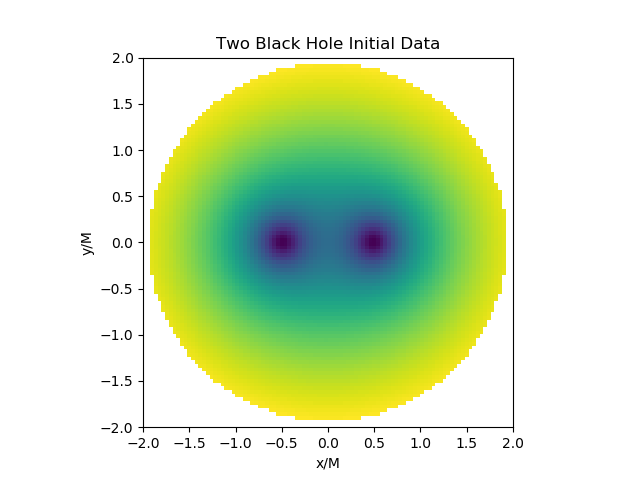

In [16]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

x32,y32,valuesCF32,valuesHam32 = np.loadtxt('out32.txt').T #Transposed for easier unpacking

pl_xmin = -2.
pl_xmax = +2.
pl_ymin = -2.
pl_ymax = +2.

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points32 = np.zeros((32*32, 2))
for i in range(32*32):
    points32[i][0] = x32[i]
    points32[i][1] = y32[i]

grid32 = griddata(points32, valuesCF32, (grid_x, grid_y), method='nearest')
grid32cub = griddata(points32, valuesCF32, (grid_x, grid_y), method='cubic')

plt.clf()
plt.title("Two Black Hole Initial Data")
plt.xlabel("x/M")
plt.ylabel("y/M")

# fig, ax = plt.subplots()
# ax.plot(grid32cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
# plt.close(fig)
plt.imshow(grid32cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
savefig("BHB.png")
from IPython.display import Image
Image("BHB.png")
# #           interpolation='nearest', cmap=cm.gist_rainbow)

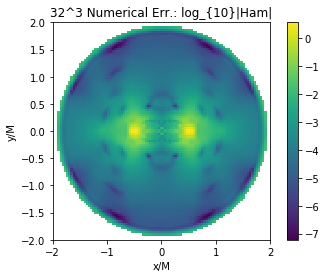

In [17]:
grid32 = griddata(points32, valuesHam32, (grid_x, grid_y), method='nearest')
grid32cub = griddata(points32, valuesHam32, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("32^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig32cub = plt.imshow(grid32cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig32cub)

<Figure size 432x288 with 0 Axes>

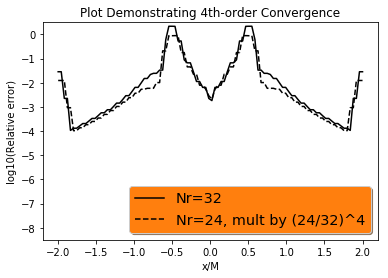

In [18]:
x24,y24,valuesCF24,valuesHam24 = np.loadtxt('out24.txt').T #Transposed for easier unpacking
points24 = np.zeros((24*24, 2))
for i in range(24*24):
    points24[i][0] = x24[i]
    points24[i][1] = y24[i]

grid24 = griddata(points24, valuesHam24, (grid_x, grid_y), method='nearest')

griddiff_24_minus_32 = np.zeros((100,100))
griddiff_24_minus_32_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid24_1darray_yeq0 = np.zeros(100)
grid32_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff_24_minus_32[i][j] = grid24[i][j] - grid32[i][j]
        griddiff_24_minus_32_1darray[count] = griddiff_24_minus_32[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid24_1darray_yeq0[i] = grid24[i][j] + np.log10((24./32.)**4)
            grid32_1darray_yeq0[i] = grid32[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid32_1darray_yeq0, 'k-', label='Nr=32')
ax.plot(gridx_1darray_yeq0, grid24_1darray_yeq0, 'k--', label='Nr=24, mult by (24/32)^4')
ax.set_ylim([-8.5,0.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()